In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. DATA COLLECTION
print("Downloading stock data...")
ticker = "JNJ"  # Apple stock
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)  # 3 years of data

stock_data = yf.download(ticker, start=start_date, end=end_date)
print(f"Downloaded {len(stock_data)} days of data for {ticker}")

/tmp/ipykernel_21604/2648009758.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed

Downloaded 751 days of data for JNJ


In [3]:
# 2. FEATURE ENGINEERING
df = stock_data.copy()

# Calculate technical indicators
df['Returns'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility'] = df['Returns'].rolling(window=20).std()
df['Volume_MA'] = df['Volume'].rolling(window=20).mean()

# Price momentum
df['Momentum'] = df['Close'] - df['Close'].shift(10)

# Target: Predict if price will go up (1) or down (0) in next day
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop NaN values
df.dropna(inplace=True)

# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 
            'MA_5', 'MA_20', 'Volatility', 'Volume_MA', 'Momentum']
X = df[features].values
y = df['Target'].values

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (731, 11), Target shape: (731,)


In [4]:
# 3. DATA PREPROCESSING
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False  # Don't shuffle time series
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 584, Test samples: 147


In [5]:
# 4. CREATE PYTORCH DATASET
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# 5. BUILD NEURAL NETWORK MODEL
class StockPredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor(input_size=X_train.shape[1]).to(device)
print(f"\nUsing device: {device}")
print(f"Model architecture:\n{model}")


Using device: cuda
Model architecture:
StockPredictor(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [7]:
# 6. TRAINING SETUP
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. TRAINING LOOP
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("\nStarting training...")
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_train += (predictions == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    # Validation phase
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_test += (predictions == y_batch).sum().item()
            total_test += y_batch.size(0)
    
    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Starting training...
Epoch [10/50]
  Train Loss: 0.6903, Train Acc: 52.57%
  Test Loss: 0.6946, Test Acc: 48.30%
Epoch [20/50]
  Train Loss: 0.6882, Train Acc: 54.45%
  Test Loss: 0.7053, Test Acc: 49.66%
Epoch [30/50]
  Train Loss: 0.6807, Train Acc: 56.68%
  Test Loss: 0.7014, Test Acc: 51.70%
Epoch [40/50]
  Train Loss: 0.6817, Train Acc: 57.19%
  Test Loss: 0.6918, Test Acc: 56.46%
Epoch [50/50]
  Train Loss: 0.6805, Train Acc: 55.65%
  Test Loss: 0.6895, Test Acc: 56.46%


In [16]:
plt.rcParams['font.family'] = 'DejaVu Serif'  # Options: 'serif', 'sans-serif', 'monospace', 'cursive', 'fantasy'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']  # Fallback fonts

# Set font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11

# Set default color cycle
aussie_colors = ['#22a6b3', '#f9ca24', '#be2edd', '#f0932b', '#4834d4', '#eb4d4b', '#130f40', '#6ab04c', '#535c68', '#c7ecee']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=aussie_colors)
plt.rcParams['figure.facecolor'] = '#FFF9F2' 
plt.rcParams['axes.facecolor'] = '#FFF9F2' 
fig_background = '#FFF9F2'  # Figure background
plot_background = '#FFF9F2'  # Plot area background


FINAL RESULTS
Final Train Accuracy: 55.65%
Final Test Accuracy: 56.46%

Training history saved as 'training_history.png'

Classification Report:
              precision    recall  f1-score   support

        Down       0.51      0.58      0.54        65
          Up       0.62      0.55      0.58        82

    accuracy                           0.56       147
   macro avg       0.57      0.57      0.56       147
weighted avg       0.57      0.56      0.57       147


Confusion Matrix:
TN: 38, FP: 27
FN: 37, TP: 45

Model saved as 'stock_predictor_model.pth'

Project complete!


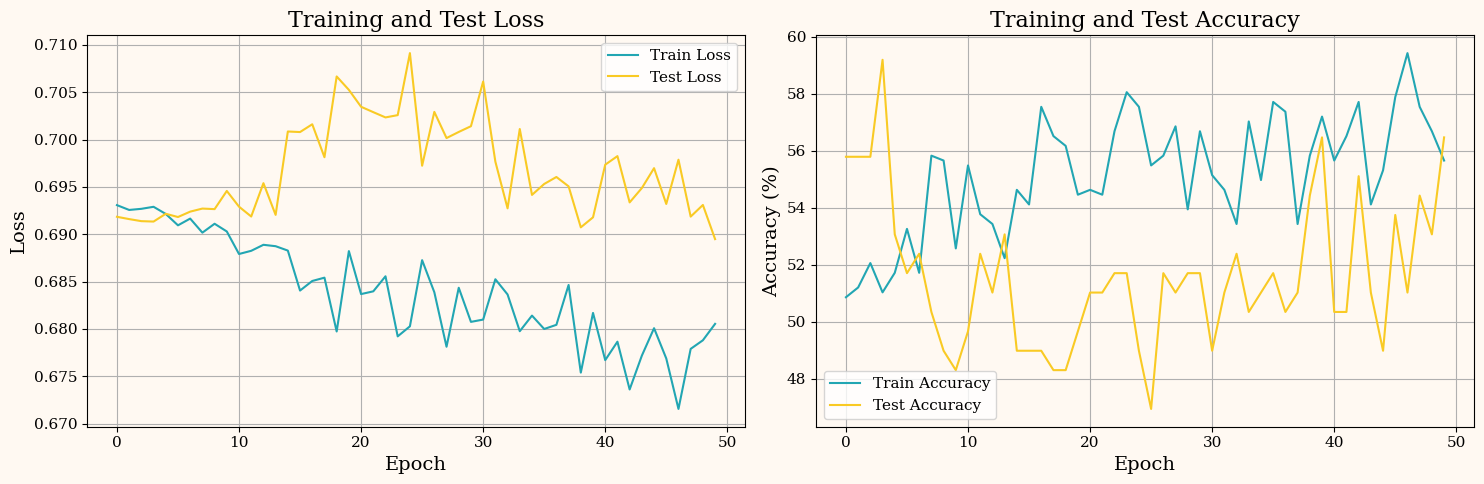

In [11]:
# 8. EVALUATION AND VISUALIZATION
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.set_facecolor(plot_background)
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.set_facecolor(plot_background)
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('outputs/training_history.png', dpi=300, bbox_inches='tight')
print("\nTraining history saved as 'training_history.png'")

# 9. MAKE PREDICTIONS ON TEST SET
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_actuals.extend(y_batch.numpy())

# Calculate additional metrics

print("\nClassification Report:")
print(classification_report(all_actuals, all_predictions, 
                          target_names=['Down', 'Up']))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_actuals, all_predictions)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# 10. SAVE MODEL
torch.save(model.state_dict(), 'stock_predictor_model.pth')
print("\nModel saved as 'stock_predictor_model.pth'")

print("\n" + "="*50)
print("Project complete!")
print("="*50)

## Stock Price Prediction with LSTM
Long Short-Term Memory (LSTM) networks are widely used for financial time series forecasting. Here's a complete implementation:


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import date

# Download stock data
end_date = date.today().strftime("%Y-%m-%d")
start_date = '2015-01-01'
df = yf.download('AAPL', start=start_date, end=end_date)

# Use closing prices
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers with dropout
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout
        )
        
        # Fully connected layer
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from the last time step
        out = self.linear(out[:, -1, :])
        return out

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = LSTMModel(input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout=0.2)
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 32
train_losses = []
test_losses = []

# Create DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        X_test_device = X_test.to(device)
        y_test_device = y_test.to(device)
        test_predictions = model(X_test_device)
        test_loss = criterion(test_predictions, y_test_device)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss.item():.6f}')

# Make predictions
model.eval()
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    test_predictions = model(X_test.to(device)).cpu().numpy()

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)

print(f'\nTest RMSE: {rmse:.4f}')
print(f'Test R² Score: {r2:.4f}')

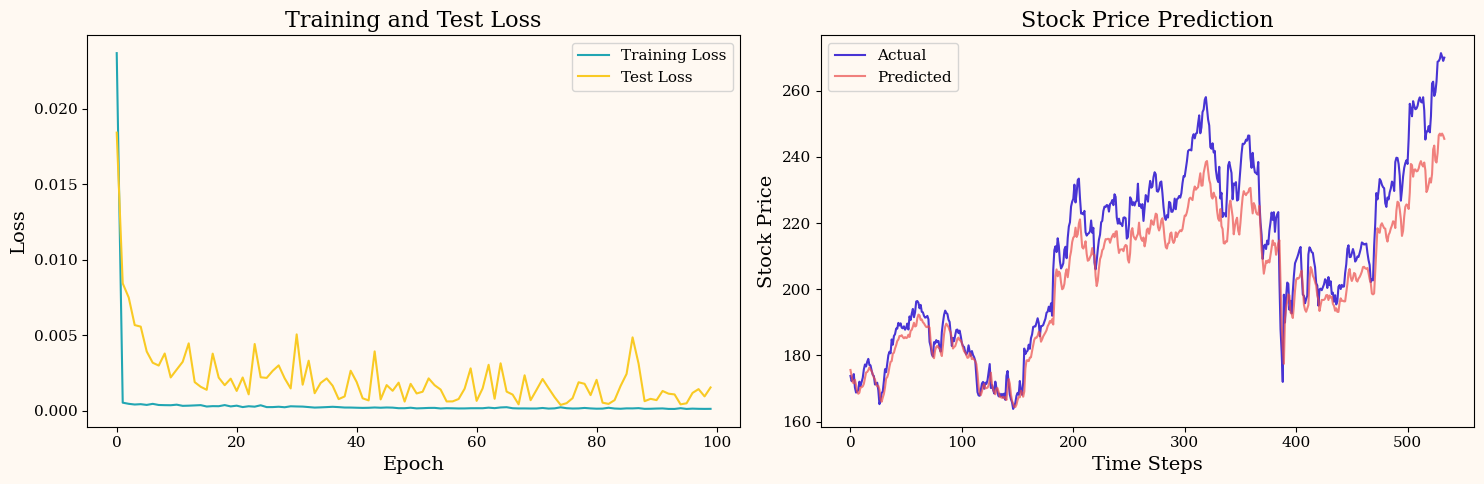

In [17]:
# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual', color=aussie_colors[4])
plt.plot(test_predictions, label='Predicted', color=aussie_colors[5], alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/LSTM_stock_prediction.png', dpi=300, bbox_inches='tight')
plt.show()